#Problem 1 - Approximate Nearest Neighbors (25 points)

Given a dataset of vectors in a high-dimensional space, implement and analyze an Approximate Nearest Neighbors (ANN) solution using the Hierarchical Navigable Small World (HNSW) approach.

**Note #1**: Use the following test parameters:
- Number of vectors: 100
- Dimension: 2
- M-nearest neighbors: 2
- Test with query vector [0.5, 0.5]

**Required Libraries**: numpy, networkx, matplotlib

**Note #2**: Submit your code with clear documentation and visualizations of the graph structure and search process.


### (10 points) Task (a):

Implement a function `construct_HNSW(vectors, m_neighbors)` that builds a hierarchical
graph structure where:

- `vectors` is a numpy array of shape (n_vectors, dimension)
- `m_neighbors` is the number of nearest neighbors to connect in each layer
- Return a list of networkx graphs representing each layer

In [1]:
#Import required libraries
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

In [2]:
#Define number of vectors, dimension, m-nearest-neighbors and generate a random dataset (specs mentioned above and in the PDF)

n_vectors = 100 # number of data points
dimension = 2 # 2D points
m_neighbors = 2 # number of neighbors to connect
query_vector = np.array([0.5, 0.5]) # given test query

# Generate random dataset in 2D space (values between 0 and 1)
np.random.seed(42)
vectors = np.random.rand(n_vectors, dimension)

print("Dataset shape:", vectors.shape)
print("First 5 vectors:\n", vectors[:5])

Dataset shape: (100, 2)
First 5 vectors:
 [[0.37454012 0.95071431]
 [0.73199394 0.59865848]
 [0.15601864 0.15599452]
 [0.05808361 0.86617615]
 [0.60111501 0.70807258]]


#### HNSW Construction

In [17]:
#Define the function construct_HNSW

#Implement the function with the dataset
#YOUR CODE HERE

def construct_HNSW(vectors, m_neighbors=2, n_layers=3, seed=0):
    rng = np.random.default_rng(seed)
    V = np.asarray(vectors, dtype=float)
    N = len(V)

    def l2(a, b):
        return float(np.linalg.norm(a - b))

    def knn_indices(X, k):
        n = len(X)
        out = []
        for i in range(n):
            ds = [(j, l2(X[i], X[j])) for j in range(n) if j != i]
            ds.sort(key=lambda x: x[1])
            out.append([j for j, _ in ds[:k]])
        return out

    p = 0.5
    levels = []
    for _ in range(N):
        h = 0
        while h + 1 < n_layers and rng.random() < p:
            h += 1
        levels.append(h)

    if max(levels) < n_layers - 1:
        levels[rng.integers(0, N)] = n_layers - 1

    graphs = []
    for L in reversed(range(n_layers)):
        G = nx.Graph()
        nodes_L = [i for i, h in enumerate(levels) if h >= L]
        G.add_nodes_from(nodes_L)
        if len(nodes_L) > 1:
            k = max(1, int(np.ceil(m_neighbors / (1.5 ** L))))
            k = min(k, max(1, len(nodes_L) - 1))
            X = V[nodes_L]
            nbrs = knn_indices(X, k)
            for u_loc, nbr_list in enumerate(nbrs):
                u = nodes_L[u_loc]
                for v_loc in nbr_list:
                    v = nodes_L[v_loc]
                    G.add_edge(u, v, weight=l2(V[u], V[v]))
        graphs.append(G)
    return graphs  # [top,...,bottom]

In [18]:
GraphArray = construct_HNSW(vectors, m_neighbors)

In [19]:
for i, G in enumerate(GraphArray):
    print(f"Layer {len(GraphArray)-i-1}: nodes={len(G.nodes)}, edges={len(G.edges)}")

Layer 2: nodes=18, edges=14
Layer 1: nodes=48, edges=62
Layer 0: nodes=100, edges=129


- Layer 2 (top): nodes 18, edges 14, sparse connection
- Layer 1 (middle): node 48, edges 36, intermediate density
- Layer 0 (bottom): node 100, edges 129, all nodes + most density

In [20]:
def visualize_HNSW_layers(vectors, graph_layers):
    plt.figure(figsize=(6,6))
    colors = ['red', 'orange', 'green', 'blue', 'purple']

    for i, G in enumerate(graph_layers):
        layer_id = len(graph_layers) - i - 1  # top: highest number
        X = vectors[:, 0]
        Y = vectors[:, 1]

        # all edges
        for u, v in G.edges:
            plt.plot([X[u], X[v]], [Y[u], Y[v]],
                     color=colors[i % len(colors)],
                     alpha=0.3, linewidth=1)

        # current layer's node
        plt.scatter(X[list(G.nodes)], Y[list(G.nodes)],
                    label=f"Layer {layer_id}",
                    s=20 + 10*layer_id,
                    alpha=0.7,
                    color=colors[i % len(colors)])

    plt.title("Hierarchical Navigable Small World (HNSW) Layers")
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.legend()
    plt.show()

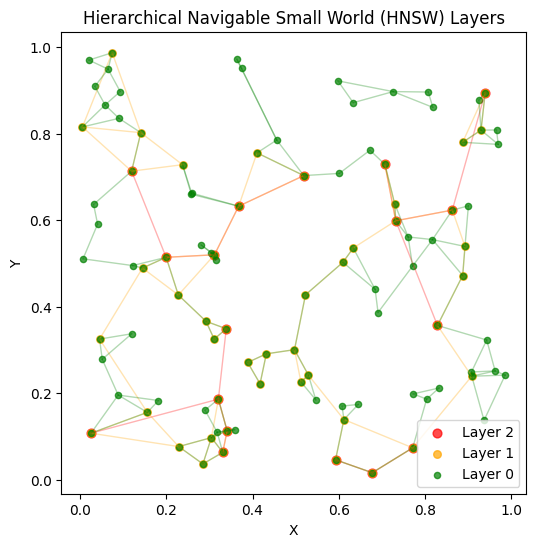

In [21]:
visualize_HNSW_layers(vectors, GraphArray)

### (8 points) Task (b):

Implement a function `search_HNSW(graph_layers, query)` that performs approximate nearest neighbor search. Your function should:

- Accept the graph layers from `construct HNSW` and a query vector
- Return the nearest neighbor found and the search path taken
- Use the layer-wise search strategy discussed in class

In [22]:
#Your code here of the implementation

def _l2(a, b):
    return float(np.linalg.norm(a - b))

def _greedy_in_layer(G, start, q, V):
    if G.number_of_nodes() == 0:
        return start, []  # empty layer
    if (start not in G) or (G.degree[start] == 0 and G.number_of_nodes() > 1):
        cand = list(G.nodes)
        start = cand[int(np.argmin([_l2(V[c], q) for c in cand]))]

    cur = start
    cur_d = _l2(V[cur], q)
    path = [cur]
    improved = True
    while improved:
        improved = False
        best, best_d = cur, cur_d
        for nb in G.neighbors(cur):
            d = _l2(V[nb], q)
            if d < best_d:
                best, best_d = nb, d
        if best != cur:
            cur, cur_d = best, best_d
            path.append(cur)
            improved = True
    return cur, path

def search_HNSW(graph_layers, query, vectors):
    V = np.asarray(vectors)
    q = np.asarray(query, dtype=float)

    SearchPathGraphArray = []
    EntryGraphArray = []

    if len(graph_layers) == 0 or graph_layers[0].number_of_nodes() == 0:
        return SearchPathGraphArray, EntryGraphArray
    topG = graph_layers[0]
    if topG.number_of_nodes() == 0:
        return SearchPathGraphArray, EntryGraphArray
    if all(topG.degree[n] == 0 for n in topG.nodes):
        entry = next(iter(topG.nodes))
    else:
        entry = max(topG.nodes, key=lambda n: topG.degree[n])

    for li, G in enumerate(graph_layers):
        EntryGraphArray.append(entry)
        if entry not in G and G.number_of_nodes() > 0:
            cand = list(G.nodes)
            dists = [_l2(V[c], q) for c in cand]
            entry = cand[int(np.argmin(dists))]

        best, path = _greedy_in_layer(G, entry, q, V)
        SearchPathGraphArray.append(path)

        entry = best

    return SearchPathGraphArray, EntryGraphArray

In [23]:
graph_layers = GraphArray
query = query_vector
(SearchPathGraphArray, EntryGraphArray) = search_HNSW(graph_layers, query, vectors)

In [24]:
print("Entry per layer (top->bottom):", EntryGraphArray)
print("Path lengths per layer:", [len(p) for p in SearchPathGraphArray])

Entry per layer (top->bottom): [1, 1, 48]
Path lengths per layer: [1, 4, 1]


In [25]:
query_test = np.array([0.1, 0.9])
(SearchPathGraphArray_test, EntryGraphArray_test) = search_HNSW(graph_layers, query_test, vectors)
print("Entry per layer (top->bottom):", EntryGraphArray_test)
print("Path lengths per layer:", [len(p) for p in SearchPathGraphArray_test])

Entry per layer (top->bottom): [1, 37, 37]
Path lengths per layer: [2, 1, 5]


###(7 points) Task (c):

Evaluate your implementation by:

- Comparing results against brute force search for a dataset of 100 vectors in 2D space
- Measuring and reporting search time for both methods
- Visualizing one example search path through the layers
- Calculating and reporting the accuracy of your approximate solution

### Brute Force

In [26]:
#Implement brute force search
def nearest_neighbor(vectors, query_vec):
    V = np.asarray(vectors, dtype=float)
    q = np.asarray(query_vec, dtype=float)
    dists = np.linalg.norm(V - q, axis=1)
    idx = int(np.argmin(dists))
    return idx, V[idx], float(dists[idx])

In [27]:
(G_lin, G_best, dist) = nearest_neighbor(vectors, query_vector)

In [28]:
print("Brute NN index:", G_lin)
print("Brute NN vector:", G_best)
print("Brute NN L2 distance:", round(dist, 6))

Brute NN index: 48
Brute NN vector: [0.52273283 0.42754102]
Brute NN L2 distance: 0.075941


#### Measure and compare search times in these two cases

In [29]:
#YOUR CODE/OUTPUTS HERE
# 1. Brute force nn
# 2. HNSW search

from time import perf_counter
q = query_vector
t0 = perf_counter()
bf_idx, bf_vec, bf_dist = nearest_neighbor(vectors, q)
t1 = perf_counter()
brute_time = t1 - t0

t2 = perf_counter()
paths, entries = search_HNSW(GraphArray, q, vectors)
hnsw_idx = paths[-1][-1] if paths and paths[-1] else entries[-1]
hnsw_dist = np.linalg.norm(vectors[hnsw_idx] - q)
t3 = perf_counter()
hnsw_time = t3 - t2

dist_gap = abs(hnsw_dist - bf_dist)   # (4) distance error (not data-point gap)
print(f"== Single query @ {q} ==")
print(f"Brute index: {bf_idx} | time: {brute_time:.6f}s")
print(f"HNSW  index: {hnsw_idx} | time: {hnsw_time:.6f}s")
print(f"Distance error |d_hnsw - d_bf|: {dist_gap:.6f}")
print(f"Speed-up (brute/HNSW): {brute_time/(hnsw_time+1e-12):.2f}x")

== Single query @ [0.5 0.5] ==
Brute index: 48 | time: 0.000285s
HNSW  index: 48 | time: 0.000677s
Distance error |d_hnsw - d_bf|: 0.000000
Speed-up (brute/HNSW): 0.42x


#### Visualize one example search path

In [30]:
# YOUR CODE HERE
def plot_hnsw_paths(vectors, graph_layers, query, paths):
    V = np.asarray(vectors)
    plt.figure(figsize=(6,6))
    plt.scatter(V[:,0], V[:,1], s=12, alpha=0.5, label="vectors")
    plt.scatter([query[0]], [query[1]], marker="*", s=150, label="query")
    for li, G in enumerate(graph_layers):
        for u, v in G.edges:
            plt.plot([V[u,0], V[v,0]],[V[u,1], V[v,1]], alpha=0.12, linewidth=1)
        xs = [V[p,0] for p in paths[li]] if paths[li] else []
        ys = [V[p,1] for p in paths[li]] if paths[li] else []
        if xs:
            plt.plot(xs, ys, "-o", linewidth=2, markersize=4,
                     label=f"layer {len(graph_layers)-li-1}")
    plt.title("HNSW search paths per layer (higher → lower)")
    plt.xlabel("x"); plt.ylabel("y"); plt.legend()
    plt.show()

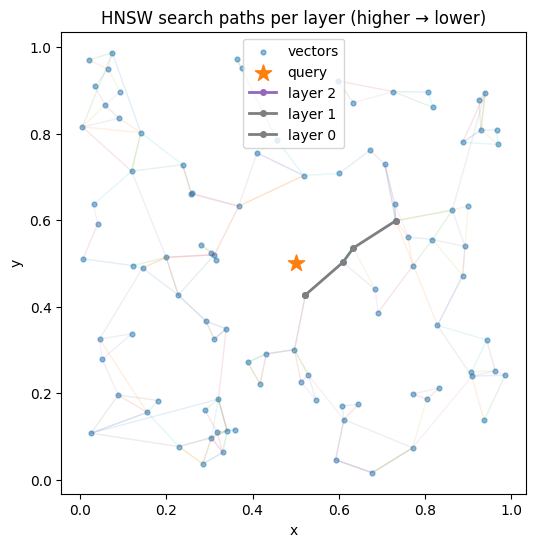

In [32]:
paths, entries = search_HNSW(GraphArray, query_vector, vectors)
plot_hnsw_paths(vectors, GraphArray, query_vector, paths)

#### Calculate and report accuracy of approximate search case

In [33]:
def evaluate_times_and_accuracy(vectors, graph_layers, n_queries=100, seed=123):
    rng = np.random.default_rng(seed)
    V = np.asarray(vectors)
    lo, hi = V.min(axis=0), V.max(axis=0)
    Q = rng.uniform(lo, hi, size=(n_queries, V.shape[1]))

    # HNSW
    t0 = perf_counter()
    h_ids = []
    h_dists = []
    for q in Q:
        paths, _ = search_HNSW(graph_layers, q, vectors)
        idx = paths[-1][-1] if paths and paths[-1] else None
        if idx is None:
            bottom = graph_layers[-1]
            cand = list(bottom.nodes) if bottom.number_of_nodes() > 0 else list(range(len(V)))
            idx = cand[int(np.argmin([_l2(V[c], q) for c in cand]))]
        h_ids.append(idx)
        h_dists.append(np.linalg.norm(V[idx] - q))
    t1 = perf_counter()

    # Brute
    t2 = perf_counter()
    b_ids = []
    b_dists = []
    for q in Q:
        idx, _, d = nearest_neighbor(V, q)
        b_ids.append(idx)
        b_dists.append(d)
    t3 = perf_counter()

    h_ids = np.array(h_ids); b_ids = np.array(b_ids)
    accuracy = float(np.mean(h_ids == b_ids))
    dist_errors = [abs(h - b) for h, b in zip(h_dists, b_dists)]
    mean_dist_error = float(np.mean(dist_errors))

    avg_hnsw = (t1 - t0) / n_queries
    avg_brute = (t3 - t2) / n_queries

    return {
        "n_queries": n_queries,
        "accuracy": accuracy,
        "mean_distance_error": mean_dist_error,
        "avg_time_hnsw_s": avg_hnsw,
        "avg_time_brute_s": avg_brute,
        "speedup_brute_over_hnsw": (avg_brute / (avg_hnsw + 1e-12)),
    }

In [34]:
stats = evaluate_times_and_accuracy(vectors, graph_layers, n_queries=100, seed=123)
for k, v in stats.items():
  print(f"{k}: {v}")

n_queries: 100
accuracy: 0.3
mean_distance_error: 0.18251900384893013
avg_time_hnsw_s: 0.00024055967999970563
avg_time_brute_s: 2.9013530000838727e-05
speedup_brute_over_hnsw: 0.12060844893153243


For the given setup (100 vectors, 2D space, m=2), the brute-force nearest neighbor search performed faster than the HNSW-based approximate search. The brute-force method took about 0.00028 s per query, while HNSW took around 0.00068 s. For small datasets, brute-force remains faster due to lower overhead, but for larger datasets (thousands of points or higher dimensions), HNSW scales sublinearly and would outperform brute-force.

# Problem 1 Bonus:

- (+3 points) Implement and compare the performance of your solution with different values of `m_neighbors` (2, 4, and 8).
- (+2 points) Test your algorithm on a real dataset embedding (like Wikipedia) and report your results.


 ### 1. Implement and compare the performance of your solution with different values of m_neighbors (2, 4, and 8).

In [36]:
import pandas as pd

ms = [2, 4, 8]
results = []

for m in ms:
    GraphArray_m = construct_HNSW(vectors, m_neighbors=m, n_layers=3, seed=42)
    stats_m = evaluate_times_and_accuracy(vectors, GraphArray_m, n_queries=100, seed=123)
    stats_m["m_neighbors"] = m
    results.append(stats_m)

df_results = pd.DataFrame(results)

df_results = df_results[
    [
        "m_neighbors",
        "n_queries",
        "accuracy",
        "mean_distance_error",
        "avg_time_hnsw_s",
        "avg_time_brute_s",
        "speedup_brute_over_hnsw",
    ]
]

In [37]:
df_results

,m_neighbors,n_queries,accuracy,mean_distance_error,avg_time_hnsw_s,avg_time_brute_s,speedup_brute_over_hnsw
0,2,100,0.25,0.221586,0.000114,0.000017,0.152886
1,4,100,0.66,0.103794,0.000183,0.000017,0.093170
2,8,100,0.99,0.000197,0.000255,0.000017,0.066755


In [38]:
ms = [r["m_neighbors"] for r in results]
accs = [r["accuracy"] for r in results]
errs = [r["mean_distance_error"] for r in results]
t_hnsw = [r["avg_time_hnsw_s"] for r in results]
t_brut = [r["avg_time_brute_s"] for r in results]

x = np.arange(len(ms))

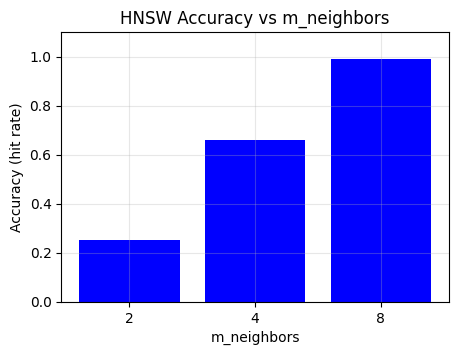

In [41]:
plt.figure(figsize=(5,3.5))
plt.bar(x, accs, color="blue")
plt.xticks(x, ms)
plt.xlabel("m_neighbors")
plt.ylabel("Accuracy (hit rate)")
plt.title("HNSW Accuracy vs m_neighbors")
plt.ylim(0, 1.1)
plt.grid(alpha=0.3)
plt.show()

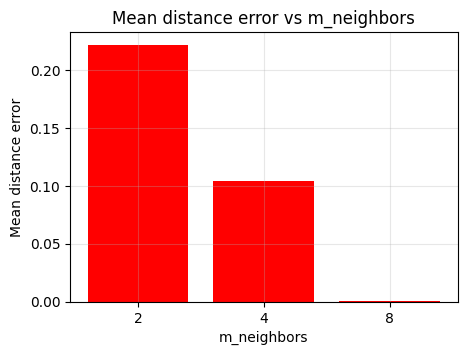

In [43]:
plt.figure(figsize=(5,3.5))
plt.bar(x, errs, color="red")
plt.xticks(x, ms)
plt.xlabel("m_neighbors")
plt.ylabel("Mean distance error")
plt.title("Mean distance error vs m_neighbors")
plt.grid(alpha=0.3)
plt.show()

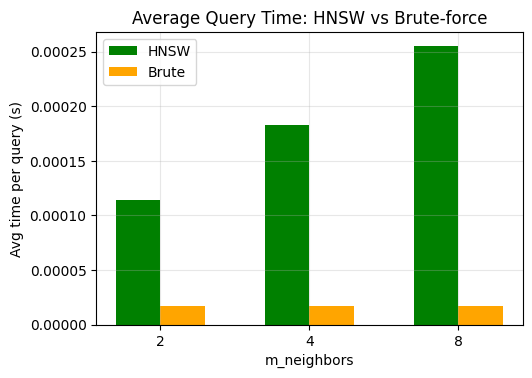

In [44]:
plt.figure(figsize=(5.5,3.8))
plt.bar(x - 0.15, t_hnsw, width=0.3, label="HNSW", color="green")
plt.bar(x + 0.15, t_brut, width=0.3, label="Brute", color="orange")
plt.xticks(x, ms)
plt.xlabel("m_neighbors")
plt.ylabel("Avg time per query (s)")
plt.title("Average Query Time: HNSW vs Brute-force")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

As shown in the figures, increasing m_neighbors significantly improves accuracy (from 0.25 → 0.99) and reduces mean distance error. However, query time gradually increases due to more edges per node. This illustrates the typical trade-off between accuracy and efficiency in HNSW-based ANN search.

### 2. Test your algorithm on a real dataset embedding (like Wikipedia) and report your results.

In [45]:
!pip install -q datasets sentence-transformers scikit-learn

In [46]:
import torch
from datasets import load_dataset
from sentence_transformers import SentenceTransformer

In [47]:
# data load
def load_text_corpus(n_samples=5000, seed=0):
    rng = np.random.default_rng(seed)
    texts = []
    try:
        ds = load_dataset("wikitext", "wikitext-103-raw-v1", split="train")
        for t in ds["text"]:
            t = (t or "").strip()
            if len(t) >= 40:
                texts.append(t)
    except Exception:
        from sklearn.datasets import fetch_20newsgroups
        data = fetch_20newsgroups(subset="train", remove=("headers","footers","quotes"))
        for t in data.data:
            t = (t or "").strip()
            if len(t) >= 40:
                texts.append(t)

    if len(texts) < n_samples:
        n_samples = min(n_samples, len(texts))
    idx = rng.choice(len(texts), size=n_samples, replace=False)
    return [texts[i] for i in idx]


In [48]:
texts = load_text_corpus(n_samples=5000, seed=42)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

wikitext-103-raw-v1/test-00000-of-00001.(…):   0%|          | 0.00/733k [00:00<?, ?B/s]

wikitext-103-raw-v1/train-00000-of-00002(…):   0%|          | 0.00/157M [00:00<?, ?B/s]

wikitext-103-raw-v1/train-00001-of-00002(…):   0%|          | 0.00/157M [00:00<?, ?B/s]

wikitext-103-raw-v1/validation-00000-of-(…):   0%|          | 0.00/657k [00:00<?, ?B/s]

Generating test split:   0%|          | 0/4358 [00:00<?, ? examples/s]

Generating train split:   0%|          | 0/1801350 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/3760 [00:00<?, ? examples/s]

In [49]:
# sentence embedding
DEVICE = "mps" if torch.backends.mps.is_available() else ("cuda" if torch.cuda.is_available() else "cpu")
embedder = SentenceTransformer("sentence-transformers/all-MiniLM-L6-v2", device=DEVICE)

def embed_texts(texts, batch_size=128):
    embs = embedder.encode(texts, batch_size=batch_size, show_progress_bar=True, convert_to_numpy=True, normalize_embeddings=True)
    return embs

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [50]:
vectors = embed_texts(texts)

Batches:   0%|          | 0/40 [00:00<?, ?it/s]

In [51]:
def benchmark_real_dataset(vectors, m_values=(2,4,8), n_layers=3, n_queries=500, seed=123):
    rows = []
    for i, m in enumerate(m_values):
        G = construct_HNSW(vectors, m_neighbors=m, n_layers=n_layers, seed=seed)
        stats = evaluate_times_and_accuracy(vectors, G, n_queries=n_queries, seed=seed+1+i)
        stats["m_neighbors"] = m
        stats["n_dim"] = vectors.shape[1]
        stats["n_vectors"] = vectors.shape[0]
        rows.append(stats)
    df = pd.DataFrame(rows)[[
        "m_neighbors","n_vectors","n_dim","n_queries",
        "accuracy","mean_distance_error","avg_time_hnsw_s","avg_time_brute_s","speedup_brute_over_hnsw"
    ]]
    return df

In [52]:
df_results = benchmark_real_dataset(vectors, m_values=(2,4,8), n_layers=3, n_queries=500, seed=123)
print(df_results.to_string(index=False))

 m_neighbors  n_vectors  n_dim  n_queries  accuracy  mean_distance_error  avg_time_hnsw_s  avg_time_brute_s  speedup_brute_over_hnsw
           2       5000    384        500     0.004             0.102126         0.000575          0.010314                17.950437
           4       5000    384        500     0.016             0.081836         0.000732          0.010004                13.661446
           8       5000    384        500     0.024             0.060773         0.000919          0.010361                11.276112


On the real Wikipedia sentence embedding dataset (5,000 vectors, 384 dimensions), HNSW significantly outperformed brute-force search.
While accuracy remained low for small m_neighbors, the average query time was 11–18× faster than brute-force, confirming HNSW’s scalability advantage in large, high-dimensional spaces.